In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 176 (delta 35), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (176/176), 1.62 MiB | 2.13 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=e612c8a2ba845893df5846b0cdae92e98dccb6598328c27ebf6893b0c7dd9b43
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8vxb3xe/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [2]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td

device = utils.set_gpu(True)

Note: GPU is available


# Conditional Data

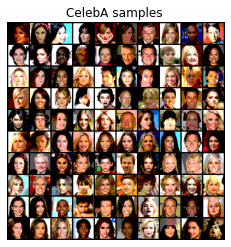

In [6]:
train_data, test_data = celeba.get_celeba(plot_sample=True)

'''
Function transforming CelebA data to conditioned CelebA dataset
'''
def get_joint_conditioned_data(data, box_size = (8, 24)):
  i, j = box_size
  x = data.copy()
  y = data.copy()
  h, w=data.shape[-2:]

  # Set the inner square to 0
  x[:, :, i:j, i:j] = 0
  
  # Set the outer square to 0
  get_ids = np.concatenate((np.arange(0, i, 1),np.arange(j, w, 1)))
  y[:, :, get_ids, :] = 0
  y[:, :, :, get_ids] = 0

  return np.concatenate((x, y), axis=1)

conditioned_train_set = get_joint_conditioned_data(train_data)
conditioned_test_set = get_joint_conditioned_data(test_data)

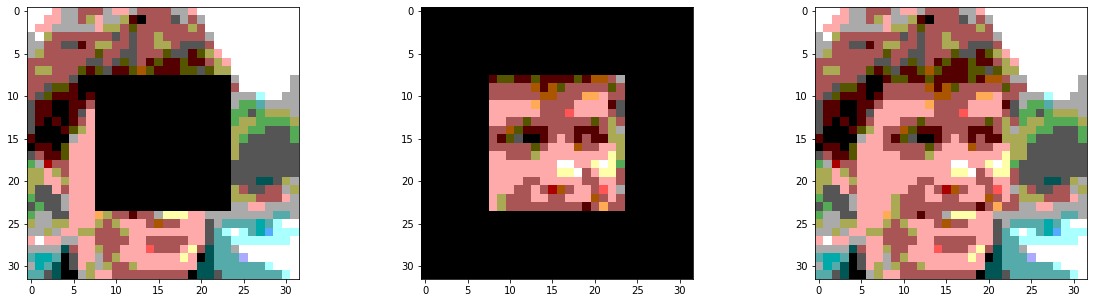

In [4]:
x, y = torch.tensor(conditioned_train_set).split(3, 1)
x = x[8].permute(1, 2, 0)
y = y[8].permute(1, 2, 0)
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(x/x.max())
ax[1].imshow(y/y.max())
ax[2].imshow((y+x)/(y+x).max())
plt.show()

# Conditional Glow

#### Nets

In [89]:

class ConditionNet(nn.Module):
    def __init__(self, in_channels, output_channels, height, width, hid_dim = 32):
        """
        A condition net. It takes in and out channels as input.
        Output is x, it is usually used to estimate the parameters for the affine transformation, hence
        the output dimensions are usually multiplied by 2, as we need two parameters.
        """
        super(ConditionNet, self).__init__()
        layers = [WeightNormConv2d(in_channels, in_channels*4, (2, 2), stride=2, padding= 0 ),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels*4, in_channels*2, (2, 2), stride=2, padding=0),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels*2, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU()]
        h, w = utils.get_layer_size([height, width], kernels=[2, 2, 2], paddings=[0, 0, 0], strides=[2, 2, 2],
                                    dilations=[1, 1, 1])
        self.net = nn.Sequential(*layers)
        layers_flatten = [nn.Linear(h * w * (in_channels), 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(),
                          nn.Linear(32, output_channels), nn.Tanh()]

        self.net_flatten = nn.Sequential(*layers_flatten)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.net(x)
        x = x.view(batch_size, -1)
        x = self.net_flatten(x)
        x = x.view(batch_size, -1, 1, 1)
        return x

class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_type):
        super(ResnetBlock, self).__init__()

        if norm_type == "wn":
          layers = [WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
              nn.LeakyReLU(),
              WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
              nn.LeakyReLU(),
              WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0)
          ]
        elif norm_type == "bn":
          layers = [nn.Conv2d(dim, dim, (1, 1), stride=1, padding=0),
              nn.BatchNorm2d(dim),
              nn.LeakyReLU(),
              nn.Conv2d(dim, dim, (3, 3), stride=1, padding=1),
              nn.BatchNorm2d(dim),
              nn.LeakyReLU(),
              nn.Conv2d(dim, dim, (1, 1), stride=1, padding=0),
              nn.BatchNorm2d(dim)
          ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

# inspired by https://github.com/addtt/ladder-vae-pytorch
class SimpleResnet(nn.Module):
    '''
    SimpleResnet can take two types of normalization, weightnormalization often used in Glow and batchnormalization for more general usage.
    Downsample will cause height/2, width/2. While upsampling will do the opposite. If no type is specified the same dimensions will be output.
    '''
    def __init__(self, in_channels, out_channels, n_filters=128, n_blocks=1, sample_type = None, norm_type = "wn"):
        super(SimpleResnet, self).__init__()
        
        if sample_type == "up":
          self.pre_conv = nn.ConvTranspose2d(in_channels, n_filters, 3, stride=2, 
                                             padding=1, output_padding=1)
        elif sample_type == "down":
          self.pre_conv = nn.Conv2d(in_channels, n_filters, 3, stride=2, padding=1)
        else:
          self.pre_conv = nn.Conv2d(in_channels, n_filters, 3, stride=1, padding=1)

        if norm_type == "wn":
            layers = [nn.utils.weight_norm(self.pre_conv),
                      nn.LeakyReLU()]
            for _ in range(n_blocks):
                layers.append(ResnetBlock(n_filters, norm_type))
            layers.append(nn.LeakyReLU())

        elif norm_type == "bn":
            layers = [self.pre_conv,
                      nn.BatchNorm2d(n_filters),
                      nn.LeakyReLU()]
            for _ in range(n_blocks):
                layers.append(ResnetBlock(n_filters, norm_type))
        else:
            print("Specify normalization type")

        self.resnet = nn.Sequential(*layers)
        self.post_conv = nn.Conv2d(n_filters, out_channels, 1, stride=1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.post_conv(x)
        return x

# Glow functions

In [127]:
def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]

class ConditionalActNorm(nn.Module):
    def __init__(self, x_size, condition_size):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size

        self.ConditionalNet = ConditionNet(in_channels = C, output_channels = 2 * Cx, 
                                           height = self.H, width = self.H)
        
    def forward(self, x, condition, logdet = 0.0, reverse=False):
  
        output = self.ConditionalNet(condition)

        scale, shift = split_feature(output)
        scale=torch.sigmoid(scale + 2.)
        log_scale = torch.log(scale)

        dlogdet = self.Hx * self.Wx * torch.sum(log_scale, dim=(1,2,3))

        if reverse == False:
            logdet += dlogdet
            x = x + shift
            x = x * scale
            return x, logdet
        else:
            logdet -= dlogdet
            x = (x - shift) / scale
            return x, logdet


class ConditionalInvConv(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalInvConv, self).__init__()

        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size
        
        self.ConditionalNet = ConditionNet(in_channels = C, output_channels= Cx * Cx, height = self.H, width = self.H)
    
    def forward(self, x, condition, logdet = None, reverse=False):

        Bx, Cx, Hx, Wx = x.size()
        B, C, H, W = condition.size()

        W = self.ConditionalNet(condition)
        W = W.view(Bx, Cx, Cx)
        

        dlogdet = Hx*Wx*torch.slogdet(W)[1]

        if reverse == False:
            W = W.view(Bx, Cx, Cx, 1, 1)
        else:
            W = torch.inverse(W.double()).float().view(Bx, Cx, Cx, 1, 1)
        
        x = x.view(1, Bx*Cx, Hx, Wx)
        B_weight, C_1_weight, C_2_weight, H_weight, W_weight = W.shape
        W = W.reshape(B_weight*C_1_weight, C_2_weight, H_weight, W_weight)

        if reverse == False:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet += dlogdet
        else:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet -= dlogdet
        return x, logdet


class ConditionalAffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalAffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        stride = [H//Hx, W//Wx]
        kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
        
        self.resize = nn.Sequential(
            nn.Conv2d(in_channels = C, out_channels = Cx*2, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = Cx*2, out_channels = Cx, kernel_size=kernel, stride=stride, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = Cx, out_channels = Cx // 2, kernel_size=3, stride=1, padding = 1)
        )

        self.resnet = SimpleResnet(in_channels = Cx, out_channels=Cx)
        

    def forward(self, x, condition, logdet=0.0, reverse=False):
        
        z1, z2 = split_feature(x, "split")
        condition = self.resize(condition)
        x = torch.cat((z1, condition), dim=1)
        
        x = self.resnet(x)
        x=torch.tanh(x)

        scale, shift = split_feature(x, "cross")
        scale = torch.sigmoid(scale + 2.)

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet += torch.sum(torch.log(scale), dim=(1, 2, 3))
        else:
            z2 = (z2 - shift) / scale
            logdet -= torch.sum(torch.log(scale), dim=(1, 2, 3)) 

        x = torch.cat((z1, z2), dim=1)
        return x, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      self.conv = nn.Sequential(
          nn.Conv2d(Cx // 2, Cx, kernel_size = 3, stride = 1, padding = 1),
          nn.Tanh()
          )
      

    def forward(self, x, logdet=0.0, reverse=False):
        
        
        if reverse == False:
            z1, z2 = split_feature(x, "split")
            out = self.conv(z1)
            mean, log_scale = split_feature(out, "cross")
            logdet += torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            mean, log_scale = split_feature(self.conv(x), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, set_extract = [1, False], K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size

        # conditional feature extractor, compress and extract conditional features.
        self.set_extract = set_extract
        if self.set_extract[1] == True:
          self.FeatureExtractorNet = SimpleResnet(in_channels=C, out_channels=self.set_extract[0], 
                                                n_filters = 32, n_blocks = 3, norm_type = "bn")

          condition_size = (B, self.set_extract[0], H, W )
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior:
          self.register_parameter("new_mean",
                                  nn.Parameter(torch.zeros([Cx, Hx, Wx]))
                                  )
          self.register_parameter("new_logs",
                                  nn.Parameter(torch.zeros([Cx, Hx, Wx]))
                                  )
        else:
          self.new_mean = torch.zeros([Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([Cx, Hx, Wx]).to(device)
        
    def set_prior(self):
        self.prior = td.Normal(self.new_mean, torch.exp(self.new_logs))

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        if self.set_extract[1] == True:
          condition = self.FeatureExtractorNet(condition)
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        if self.set_extract[1] == True:
          condition = self.FeatureExtractorNet(condition)
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        dims = torch.prod(torch.tensor(x.shape[1:]))
        #fix bins here, currently set to 256 (huh?)
        bits_per_dim = torch.tensor([-np.log(256.) * dims]*x.shape[0]).to(device)
        z, obj = self.f(x, condition, bits_per_dim)
        self.set_prior()
        obj += torch.sum(self.prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims)
        return z, nll

    def sample(self, z, condition, num_samples):
        self.set_prior()
        with torch.no_grad():
          if z == None:
            z = self.prior.rsample(torch.Size([num_samples])).to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

# Trainer

In [128]:
batch_size = 32
class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        #change here for new input
        self.flow = GlowConditional((batch_size, 3, 32, 32), (batch_size, 3, 32, 32), K=4, L=2, learn_prior = True).to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train_loader = torch.utils.data.DataLoader(conditioned_train_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=batch_size, shuffle=False)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            max_value = 4.0
            x /= max_value

            # Taking into account boundary
            x *= 0.9
            x += 0.05
            #Logit operation
            logit = torch.log(x) - torch.log(1.0 - x)
            
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(max_value))
            
            return logit, torch.mean(torch.sum(log_det, dim=(1, 2, 3))) / float(np.log(2.) *(3*32*32))


    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                image = Variable(image).to(device)

                logit_x, log_det = self.preprocess(image.float(), dequantize=True)
                condition, logit_x = logit_x.split(3, 1)
                
                z, log_prob = self.flow.log_prob(logit_x, condition)
                log_prob += log_det
                

                batch_loss = torch.mean(log_prob)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 75 == 0:
                self.save_model("GlowConditional{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)

        return train_losses

    def validate(self):
      return "Not Yet Implemented"

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

# Execution

In [129]:
solver = Solver(n_epochs=30, learning_rate=0.001)
solver.build()
train = solver.train()

Epoch 1 Loss: 5.22


KeyboardInterrupt: ignored

# Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


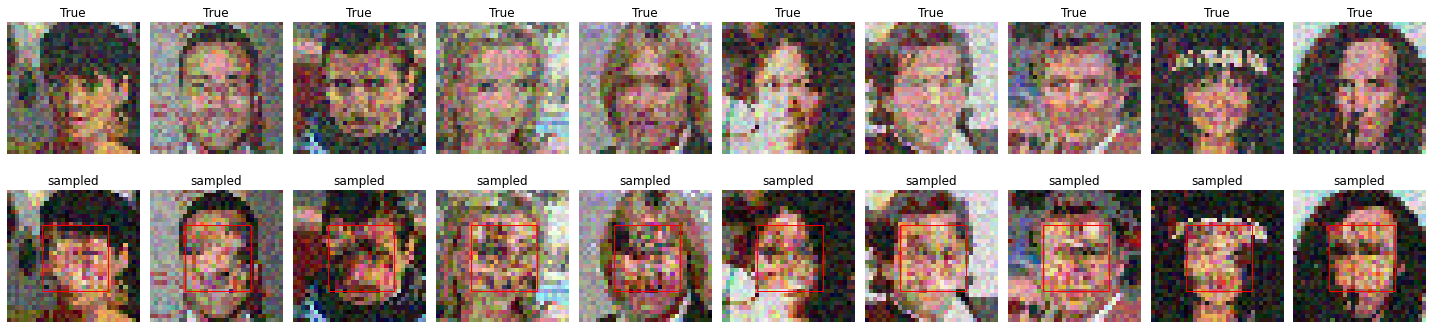

In [130]:
import matplotlib.patches as patches
test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=batch_size, shuffle=False, pin_memory=False)
x=next(iter(test_loader)).to(device)

#Preprocess
x, log_det = solver.preprocess(x, dequantize=True)
condition_x, x = x.split(3, dim=1)

with torch.no_grad():
  samples, log_det=solver.flow.sample(z=None, condition=condition_x.to(device), num_samples = 32)
  

# Preprocess samples
samples = solver.preprocess(samples, dequantize=False, reverse=True)
conzre = solver.preprocess(condition_x, dequantize=False, reverse=True)
zre = solver.preprocess(x, dequantize=False, reverse=True)


fig, axes = plt.subplots(2, 10 , figsize = (20,5))

j=0
k=0
for i in range(0, 10):
  img_1 = ((conzre[i]+zre[i])/4*4)
  
  axes[k*2, j].imshow(img_1.div(img_1.max()).permute(1,2,0).detach().cpu().numpy())
  axes[k*2, j].set_title('True')
  axes[k*2, j].set_axis_off()
  kk = conzre[i]
  kk[:,8:24,8:24] = samples[i,:,8:24,8:24]
  axes[k*2+1, j].imshow((kk.div(kk.max())).permute(1,2,0).detach().cpu().numpy())
  axes[k*2+1, j].set_title('sampled')
  axes[k*2+1, j].set_axis_off()
  rect = patches.Rectangle((8,8),24-8,24-8,linewidth=1,edgecolor='r',facecolor='none')
  axes[k*2+1, j].add_patch(rect)
  k+=1
  if k*2 % 2 == 0:
    j += 1
    k = 0

fig.tight_layout()